# **Simulation Hedy 2024 (variable Data)**

Team: TU Wien Space Team \
Project: Lamarr \
Rocket: Hedy \


## Installs

In this section all needed libraries are installed and the needed classes imported

In [19]:
!pip install "netCDF4<1.6.0"

Defaulting to user installation because normal site-packages is not writeable
  Using cached netCDF4-1.5.8.tar.gz (767 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [27 lines of output]
      reading from setup.cfg...
      Package hdf5 was not found in the pkg-config search path.
      Perhaps you should add the directory containing `hdf5.pc'
      to the PKG_CONFIG_PATH environment variable
      Package 'hdf5' not found
      
          HDF5_DIR environment variable not set, checking some standard locations ..
      checking /home/diego/include ...
      hdf5 headers not found in /home/diego/include
      checking /usr/local/include ...
      hdf5 headers not found in /usr/local/include
      checking /sw/include ...
      hdf5 headers not found in /sw/include
      checking /opt/include ...
      hdf5 headers not found in /opt/include
      checking /opt/local/incl

In [20]:
pip install rocketpy

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [21]:
pip install CoolProp

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [22]:
from rocketpy import Environment, SolidMotor, Rocket, Flight, Fluid, LiquidMotor, CylindricalTank, MassFlowRateBasedTank, TrapezoidalFins, FreeFormFins, EllipticalFins, RailButtons, NoseCone, Tail, Parachute
from math import exp
from math import pi
import datetime
import CoolProp.CoolProp as CP
from CoolProp.CoolProp import PropsSI
from rocketpy.mathutils import Function

## Configuration

The length unit chosen here is millimeters to keep the values more readable. If necessary, values should be converted accordingly.

In [31]:
# Rocket configuration data
env_config = {
    "date" : (2025, 3, 18, 13, 00, 00),   # yyyy, mm, dd, hh, mm, ss
    "latitude" : 39.12368,                # Launch latitude    #Preset
    "longitude" : -8.03333,               # Launch longitude   #Preset
    "timezone" : "Europe/Lisbon"          # GMT+1   #Preset
}
motor_config = {
    "burn_time" : 5.1,                      # s       #calculated
    "holddown_time" : 1.1,                # s       #calculated

    "nitrogen_tank" : {
        "length" : 235.411,               # mm
        "CG_lox" : 2622.95,               # mm
        "CG_ethanol" : 1422.1595,         # mm
        "outer_diameter": 93,             # mm
        "thickness" : 2,                  # mm
        "massflow" : 0.03,                # kg/s   #Estimate
    },
    "ethanol_tank" : {
        "length" : 573.61485,             # mm
        "CG" : 825.55,                    # mm
        "outer_diameter": 115,            # mm
        "thickness" : 2.5,                # mm
        "massflow" : 0.5,                 # kg/s   #tested
    },
    "lox_tank" : {
        "length" : 573.978,               # mm
        "CG" : 1932.5205,                 # mm
        "outer_diameter" : 115,           # mm
        "thickness" : 2.5,                # mm
        "massflow" : 0.6,                 # kg/s   #tested
    },
    "nozzle" : {
        "diameter" : 75,                  # mm
        "position" : -40,                 # mm
    },


    "use_preset_ethanol_mass" : False,
    "use_preset_lox_mass" : False,
    "use_max_nitrogen_mass" : True,
    "use_max_ethanol_mass" : True,
    "use_max_lox_mass" : True,
    "use_static_thrust": True,
    "thrust": 2000,                       #N
    "overfill_percentage" : 0.001,        # %       #Preset

    "mass" : {
      "ethanol" : 2.7,                    # kg     #Preset
      "lox" : 3.5,                        # kg     #Preset
      "ice" : 0.5                         # kg     #Preset
    },
    "temperature" : {
        "ethanol" : 298.15,               # K      #Preset (= 25°C)
        "lox" : 73.15,                    # K      #Preset (= -200°C)
        "nitrogen" : 298.15             # K      #Preset (= 25°C)
    },
    "pressure" : {
        "ethanol" : 3000000,              # Pa     #Preset
        "lox" : 3000000,                  # Pa     #Preset
        "nitrogen" : 30000000           # Pa     #Preset
    }
}

rocket_config = {
    "account_for_ice" : True,
    "total_weight" : 16580,               # g       #weighed
    "total_length" : 3765,                # mm
    "total_CG" : 1813,                    # mm      #calculated
    "moment_of_intertia_Z" : 0.0255,      # kg*m^2  #calculated
    "moment_of_intertia_XY" : 16.8,       # kg*m^2  #calculated
    "nosecone_length" : 650,              # mm
    "railbuttons" : {
        "upper" : 1646.67,                # mm
        "lower" : 297.5,                  # mm
    },
    "tailcone" : {
        "diameter" : 97.8,                # mm
        "length" : 245.643,               # mm
        "cylindrical_height" : 34.8,      # mm
    },
    "rocket" : {
        "thickness" : 1.4,                # mm
        "diameter" : 132.8,               # mm
    },
    "fins" : {
        "name" : "Biconvex",
        "amount" : 4,
        "root_chord" : 199.0211,          # mm
        "tip_chord" : 79.4,               # mm
        "span" : 96.4,                    # mm
        "sweep_length" : 63.892,          # mm
        "position" : 233,                 # mm
        "shape_points" : ((0,0),
                          (-0.0265,0.0036),
                          (-0.0902,0.114),
                          (-0.170,0.114),
                          (-0.234,0.017),
                          (-0.0265,0.00359),
                          (0,0))
    },
    "parachutes" : {
        "main" : {
            "cd_s" : 6.911503837897546,
            "trigger" : 450,              # m      #Preset
            "sampling_rate" : 105,        # hz     #Preset
            "lag" : 4,                    # s      #Tested
            "noise" : (0, 8.3, 0.5)       # (pa, pa, pa)
        },
        "drogue" : {
            "cd_s" : 0.336875,
            "trigger" : "apogee",         # m      #Preset
            "sampling_rate" : 105,        # hz     #Preset
            "lag" : 1,                    # s      #tested
            "noise" : (0, 8.3, 0.5)       # (pa, pa, pa)
        }
    }
}
flight_config = {
    "rail_length" : 11,                   # m       #Preset
    "inclination" : 86,                   # °       #Preset
    "heading" : 133,                      # °       #Preset
}

data = range(800, 1201, 50)
print("Data:")
for i in data:
  print(i)

Data:
800
850
900
950
1000
1050
1100
1150
1200


## Environments Initialization




In this Section the environments are initialized.
*   **envForecast**: environment with the weather data from the wyoming-sounding data source at the location and date of EuRoc
*   **envNormal**: normalized environment with standard atmospheric values at the time and location of EuRoc
*   **envCostom**: custom environment with variable values for temperature and windspeed


/var/data/python/lib/python3.12/site-packages/rocketpy/environment/tools.py:309: UserWarning: Exact chosen launch time is not available in the provided file, using 2025-03-18 12:00:00 UTC instead.
  warnings.warn(



Gravity Details

Acceleration of gravity at surface level:    9.7798 m/s²
Acceleration of gravity at  79.252 km (ASL): 9.5401 m/s²


Launch Site Details

Launch Date: 2025-03-18 13:00:00 UTC | 2025-03-18 13:00:00 Europe/Lisbon
Launch Site Latitude: 39.12368°
Launch Site Longitude: -8.03333°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 158.0 m


Atmospheric Model Details

Atmospheric Model Type: Forecast
Forecast Maximum Height: 79.252 km
Forecast Time Period: from 2025-03-06 06:00:00 to 2025-03-22 06:00:00 utc
Forecast Hour Interval: 3 hrs
Forecast Latitude Range: From -90.0° to 90.0°
Forecast Longitude Range: From 0.0° to 359.75°

Surface Atmospheric Conditions

Surface Wind Speed: 5.77 m/s
Surface Wind Direction: 308.36°
Surface Wind Heading: 128.36°
Surface Pressure: 992.18 hPa
Surface Temperature: 282.60 K
Surface Air Density: 1.223 kg/m³
Surface Speed of Sound: 337.00 m/s


Earth Model De

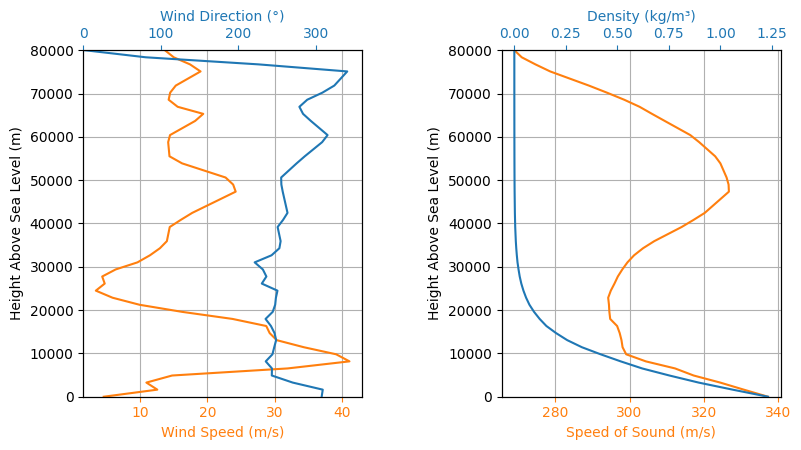


Gravity Details

Acceleration of gravity at surface level:    9.7803 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5379 m/s²


Launch Site Details

Launch Date: 2025-03-18 13:00:00 UTC | 2025-03-18 13:00:00 Europe/Lisbon
Launch Site Latitude: 39.12368°
Launch Site Longitude: -8.03333°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 0.0 m


Atmospheric Model Details

Atmospheric Model Type: standard_atmosphere
standard_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 0.00 m/s
Surface Wind Direction: 0.00°
Surface Wind Heading: 0.00°
Surface Pressure: 1013.25 hPa
Surface Temperature: 288.15 K
Surface Air Density: 1.225 kg/m³
Surface Speed of Sound: 340.29 m/s


Earth Model Details

Earth Radius at Launch site: 6378.14 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



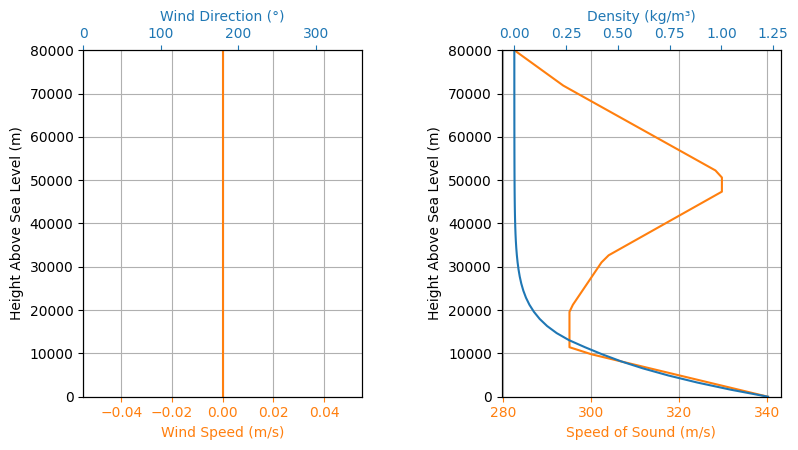


Gravity Details

Acceleration of gravity at surface level:    9.7803 m/s²
Acceleration of gravity at  80.000 km (ASL): 9.5379 m/s²


Launch Site Details

Launch Site Latitude: 39.12368°
Launch Site Longitude: -8.03333°
Reference Datum: SIRGAS2000
Launch Site UTM coordinates: 166021.44 W|E    0.00 N
Launch Site UTM zone: 31N
Launch Site Surface Elevation: 0.0 m


Atmospheric Model Details

Atmospheric Model Type: custom_atmosphere
custom_atmosphere Maximum Height: 80.000 km

Surface Atmospheric Conditions

Surface Wind Speed: 10.00 m/s
Surface Wind Direction: 270.00°
Surface Wind Heading: 90.00°
Surface Pressure: 1013.25 hPa
Surface Temperature: 303.15 K
Surface Air Density: 1.164 kg/m³
Surface Speed of Sound: 349.04 m/s


Earth Model Details

Earth Radius at Launch site: 6378.14 km
Semi-major Axis: 6378.14 km
Semi-minor Axis: 6356.75 km
Flattening: 0.0034


Atmospheric Model Plots



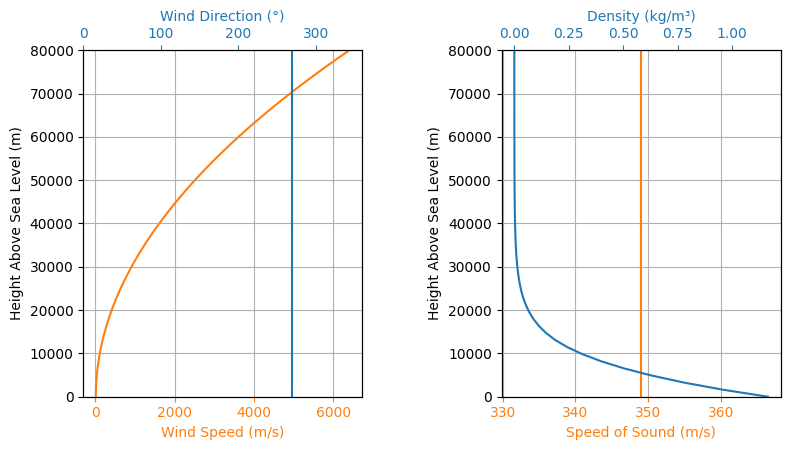

In [24]:
#Ponte de Sor: 39.12368, -8.03333
#EUROC: 09.-15.10.2024
#possible launch date: 11.10.2024

#Environment based on Forecast data for the EuRoC 2024
envForecast = Environment()

envForecast.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envForecast.set_elevation(0)#"Open-Elevation")
envForecast.set_date(
    env_config["date"],
    timezone = env_config["timezone"]
)

envForecast.set_atmospheric_model(type="Forecast", file="GFS")
envForecast.info()


#Environment based on standard values
envNormal = Environment()
envNormal.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envNormal.set_elevation(0)#"Open-Elevation")
envNormal.set_date(env_config["date"], timezone = env_config["timezone"])
envNormal.set_atmospheric_model(type = "standard_atmosphere")
envNormal.info()

#Environment based on Custom Data
envCustom = Environment()
envCustom.set_location(latitude = env_config["latitude"], longitude = env_config["longitude"])
envCustom.set_atmospheric_model(type = "custom_atmosphere", temperature = 30 + 273.15, wind_u = lambda t:10 + (t /1000)**2, wind_v = 0)
envCustom.info()

## Simulation

### Tanks / Engine



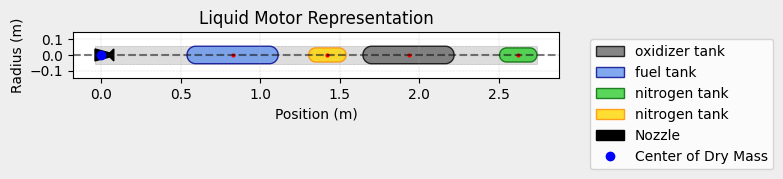

10.455524555734273
9.78500734050037


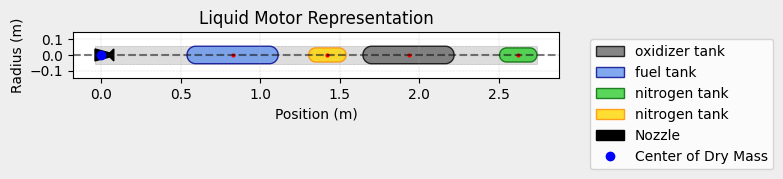

9.775728993632258
9.73000734050037


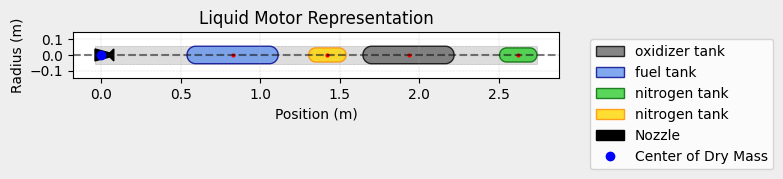

9.1714662717638
9.67500734050037


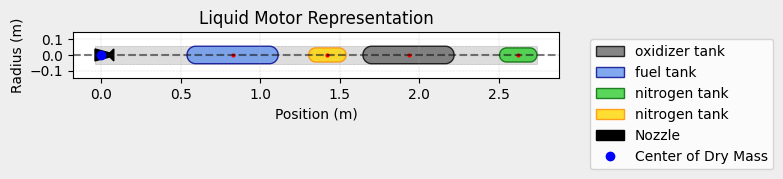

8.630810152197284
9.62000734050037


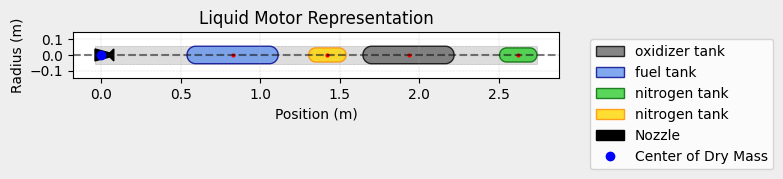

8.14421964458742
9.565007340500369


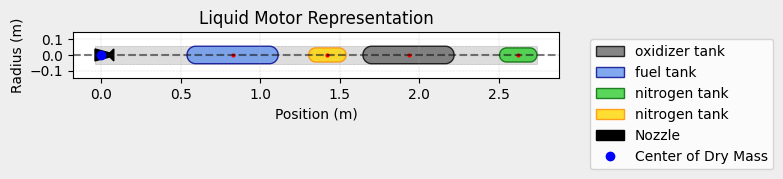

7.703971090083257
9.510007340500369


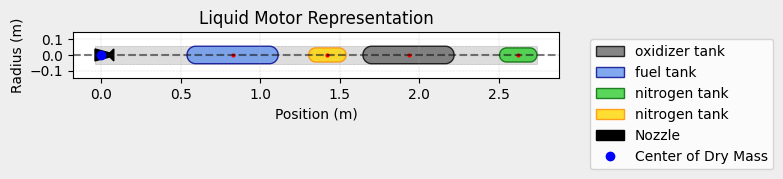

7.303745131443108
9.455007340500368


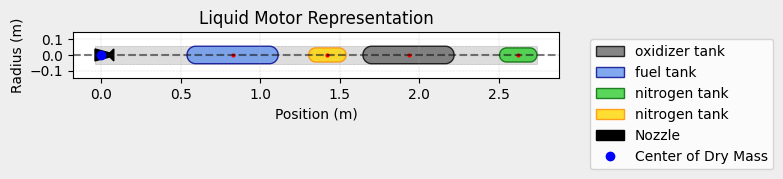

6.938321430076018
9.40000734050037


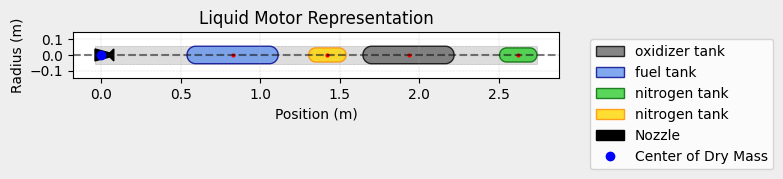

6.603349703822849
9.345007340500368


In [32]:
#Burn time
t_burn              = motor_config["burn_time"]       #s
#holddown time
t_holddown          = motor_config["holddown_time"]   #s


# tank height
h_nitrogen_tank     = motor_config["nitrogen_tank"]["length"]     / 1000  #m
h_ethanol_tank      = motor_config["ethanol_tank"]["length"]      / 1000  #m
h_lox_tank          = motor_config["lox_tank"]["length"]          / 1000  #m
#OuterDiameter
OD_nitrogen_tank    = motor_config["nitrogen_tank"]["outer_diameter"]   / 1000  #m
OD_ethanol_tank     = motor_config["ethanol_tank"]["outer_diameter"]    / 1000  #m
OD_lox_tank         = motor_config["lox_tank"]["outer_diameter"]        / 1000  #m
#Thickness
Th_nitrogen_tank    = motor_config["nitrogen_tank"]["thickness"]  / 1000  #m
Th_ethanol_tank     = motor_config["ethanol_tank"]["thickness"]   / 1000  #m
Th_lox_tank         = motor_config["lox_tank"]["thickness"]       / 1000  #m
#massflows
mdot_nitrogen     = motor_config["nitrogen_tank"] ["massflow"]    #kg/s
mdot_ethanol      = motor_config["ethanol_tank"]["massflow"]      #kg/s
mdot_lox          = motor_config["lox_tank"]["massflow"]          #kg/s
#nozzle
nozzle_diameter     = motor_config["nozzle"]["diameter"]          / 1000  #m
nozzle_position     = motor_config["nozzle"]["position"]          / 1000  #m


#preset mass flag
use_preset_ethanol_mass   = motor_config["use_preset_ethanol_mass"]
use_preset_lox_mass       = motor_config["use_preset_lox_mass"]
#max mass flag
use_max_nitrogen_mass   = motor_config["use_max_nitrogen_mass"]
use_max_ethanol_mass    = motor_config["use_max_ethanol_mass"]
use_max_lox_mass        = motor_config["use_max_lox_mass"]
#static thrust flag
use_static_thrust   = motor_config["use_static_thrust"]
#thrust
thrust              = motor_config["thrust"]                          #N
#Overfill
overfill_percentage = motor_config["overfill_percentage"]             #%


#masses
m_ethanol_preset    = motor_config["mass"]["ethanol"]                 #kg
m_lox_preset        = motor_config["mass"]["lox"]                     #kg
# Temperature Lox & Ethanol
T_nitrogen        = motor_config["temperature"]["nitrogen"]           #K  (=25°C)
T_ethanol         = motor_config["temperature"]["ethanol"]            #K  (=25°C)
T_lox             = motor_config["temperature"]["lox"]                #K
# pressure LOX & Ethanol
p_nitrogen        = motor_config["pressure"]["nitrogen"]              #Pa
p_ethanol         = motor_config["pressure"]["ethanol"]               #Pa
p_lox             = motor_config["pressure"]["lox"]                   #Pa




nitrogen_tanks = []
ethanol_tanks = []
lox_tanks = []
engines = []

for i in data :
  mdot_lox = 1.3 *((i/1000)/(1.3+1))
  mdot_ethanol = ((i/1000)/(1.3+1))

  # inner diameter
  ID_nitrogen_tank = OD_nitrogen_tank - (2* Th_nitrogen_tank)     # m
  ID_ethanol_tank = OD_ethanol_tank - (2 * Th_ethanol_tank)       # m
  ID_lox_tank = OD_lox_tank - (2 * Th_lox_tank)                   # m

  # Propellants
  # mass
  m_nitrogen_calculated = mdot_nitrogen * (t_burn)                # kg
  m_ethanol_calculated = mdot_ethanol * (t_burn)                  # kg
  m_lox_calculated = mdot_lox * (t_burn)                          # kg

  # define density
  rho_nitrogen = CP.PropsSI("D","T",T_nitrogen,"P|gas",p_nitrogen,"N2")             # kg/m^3
  rho_ethanol = CP.PropsSI("D", "T|liquid", T_ethanol, "P", p_ethanol, "ethanol")   # kg/m^3
  rho_lox = CP.PropsSI("D", "T|liquid", T_lox, "P", p_lox, "oxygen")                # kg/m^3

  # define fluids
  nitrogen = Fluid(name = "N2", density = rho_nitrogen)
  ethanol = Fluid(name = "ethanol", density = rho_ethanol)
  lox = Fluid(name = "LOX", density = rho_lox)

  # define tanks geometry
  nitrogen_tank_shape = CylindricalTank(radius = ID_nitrogen_tank / 2, height = h_nitrogen_tank, spherical_caps = True)
  ethanol_tank_shape = CylindricalTank(radius = ID_ethanol_tank / 2, height = h_ethanol_tank, spherical_caps = True)
  lox_tank_shape = CylindricalTank(radius = ID_lox_tank / 2, height = h_lox_tank, spherical_caps = True)




  v_nitrogen_tank = nitrogen_tank_shape.volume(h_nitrogen_tank/2)   # m³
  v_ethanol_tank = ethanol_tank_shape.volume(h_ethanol_tank/2)      # m³
  v_lox_tank = lox_tank_shape.volume(h_lox_tank/2)                  # m³

  m_nitrogen_max = v_nitrogen_tank * rho_nitrogen                   # m
  m_ethanol_max = v_ethanol_tank * rho_ethanol                      # m
  m_lox_max = v_lox_tank * rho_lox                                  # m

  t_burn_nitrogen = (m_nitrogen_max / mdot_nitrogen)-0.001          # s


  if(use_max_ethanol_mass and use_preset_ethanol_mass):
    print("Cannot use preset and max!")
    m_enthanol = 100/0

  if(use_max_lox_mass and use_preset_lox_mass):
    print("Cannot use preset and max!")
    m_lox = 100/0



  if(use_max_nitrogen_mass):
    m_nitrogen = m_nitrogen_max
  else:
    m_nitrogen = m_nitrogen_calculated + (overfill_percentage/100 * t_burn * mdot_nitrogen)

  if(use_preset_ethanol_mass):
    m_ethanol = m_ethanol_preset
  elif(use_max_ethanol_mass):
    m_ethanol = m_ethanol_max
  else:
    m_ethanol = m_ethanol_calculated + (overfill_percentage/100 * t_burn * mdot_ethanol)

  if(use_preset_lox_mass):
    m_lox = m_lox_preset
  elif(use_max_lox_mass):
    m_lox = m_lox_max
  else:
    m_lox = m_lox_calculated + (overfill_percentage/100 * t_burn * mdot_lox)

  if(use_max_ethanol_mass and use_max_lox_mass):
    t_burn_ethanol = (m_ethanol_max / mdot_ethanol)
    t_burn_lox = (m_lox_max / mdot_lox)
    if(t_burn_ethanol<t_burn_lox):
      t_burn = t_burn_ethanol-0.001
    else:
      t_burn = t_burn_lox-0.001

  if(use_static_thrust):
    thrust_curve = lambda t: thrust
  else:
    thrust_curve = "thrust_curve.csv"

  #account for holddown
  t_burn -= t_holddown
  m_lox -= mdot_lox * t_holddown
  m_ethanol -= mdot_ethanol * t_holddown

  if(t_burn_nitrogen<t_burn):
    print("WARNING: TOO LITTLE NITROGEN, UNKNOWN EFFECTS")


  # define tanks
  nitrogen_tank = MassFlowRateBasedTank(
        name = "nitrogen tank",
        geometry = nitrogen_tank_shape,
        flux_time = t_burn_nitrogen,                        # s
        initial_liquid_mass = 0,                            # kg
        initial_gas_mass = m_nitrogen,                      # kg
        liquid_mass_flow_rate_in = 0,                       # kg/s
        liquid_mass_flow_rate_out = 0,                      # kg/s
        gas_mass_flow_rate_in = 0,                          # kg/s
        gas_mass_flow_rate_out = lambda t: mdot_nitrogen,   # ks/s
        liquid = Fluid(name = "liquid", density = 0.0001),  # ignore
        gas = nitrogen,
    )

  ethanol_tank = MassFlowRateBasedTank(
        name = "fuel tank",
        geometry = ethanol_tank_shape,
        flux_time = t_burn,                                 # s
        initial_liquid_mass = m_ethanol,                    # kg
        initial_gas_mass = 0,                               # kg
        liquid_mass_flow_rate_in = 0,                       # kg/s
        liquid_mass_flow_rate_out = lambda t: mdot_ethanol, # kg/s
        gas_mass_flow_rate_in = lambda t: mdot_nitrogen,    # kg/s
        gas_mass_flow_rate_out = 0,                         # kg/s
        liquid = ethanol,
        gas = nitrogen,
    )

  lox_tank = MassFlowRateBasedTank(
        name = "oxidizer tank",
        geometry = lox_tank_shape,
        flux_time = t_burn,                                 # s
        initial_liquid_mass = m_lox,                        # kg
        initial_gas_mass = 0,                               # kg
        liquid_mass_flow_rate_in = 0,                       # kg/s
        liquid_mass_flow_rate_out = lambda t: mdot_lox,     # kg/s
        gas_mass_flow_rate_in = lambda t: mdot_nitrogen,    # kg/s
        gas_mass_flow_rate_out = 0,                         # kg/s
        liquid = lox,
        gas = nitrogen,
    )

  skuld = LiquidMotor(
      dry_mass = 0.0001,                  # kg
      dry_inertia = (0,0,0),              # kg*m^2
      center_of_dry_mass_position = 0,    # m

      nozzle_radius = nozzle_diameter /2, # m
      nozzle_position = nozzle_position,  # m

      thrust_source = thrust_curve,       # N
      burn_time = t_burn,                 # s
      coordinate_system_orientation = "nozzle_to_combustion_chamber"
  )

  skuld.add_tank(tank = lox_tank, position =        motor_config["lox_tank"]["CG"]                /1000)
  skuld.add_tank(tank = ethanol_tank, position =    motor_config["ethanol_tank"]["CG"]            /1000)
  skuld.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_lox"]       /1000)
  skuld.add_tank(tank = nitrogen_tank, position =   motor_config["nitrogen_tank"]["CG_ethanol"]   /1000)

  nitrogen_tanks.append(nitrogen_tank)
  ethanol_tanks.append(ethanol_tank)
  lox_tanks.append(lox_tank)
  engines.append(skuld)
  skuld.draw()
  print(t_burn)
  print(m_lox+m_ethanol+m_nitrogen)
  #skuld.all_info()

### Rocket components

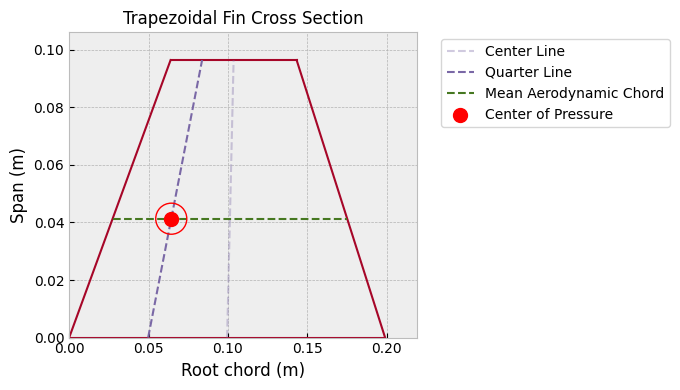

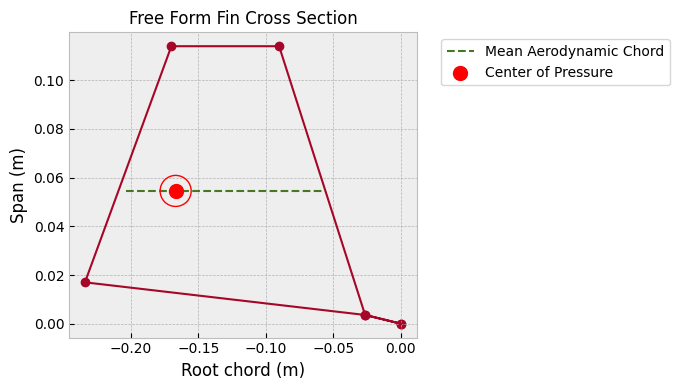

In [33]:
#rocket
rocket_length     = rocket_config["total_length"]         / 1000  #m
rocket_diameter   = rocket_config["rocket"]["diameter"]   / 1000  #m
rocket_thickness  = rocket_config["rocket"]["thickness"]  / 1000  #m

nose_cone = NoseCone(
    length = (rocket_config["nosecone_length"]-100)/1000, # m
    base_radius = rocket_diameter/2,                      # m
    kind = "lv haack"
)

tailcone_cylindrical    = rocket_config["tailcone"]["cylindrical_height"] / 1000 # m
tailcone_length         = rocket_config["tailcone"]["length"]             / 1000 # m
tailcone_bottom_radius  = rocket_config["tailcone"]["diameter"]        /2 / 1000 # m

tail = Tail(
    top_radius = rocket_diameter /2,        # m
    bottom_radius = tailcone_bottom_radius, # m
    length = tailcone_length,               # m
    rocket_radius = rocket_diameter/2       # m
)

fin_amount        = rocket_config["fins"]["amount"]
fin_name          = rocket_config["fins"]["name"]
fin_position      = rocket_config["fins"]["position"]     / 1000  # m
fin_root_chord    = rocket_config["fins"]["root_chord"]   / 1000  # m
fin_tip_chord     = rocket_config["fins"]["tip_chord"]    / 1000  # m
fin_span          = rocket_config["fins"]["span"]         / 1000  # m
fin_sweep_length  = rocket_config["fins"]["sweep_length"] / 1000  # m
fin_shape_points  = rocket_config["fins"]["shape_points"]

trapezoidal_fin_set = TrapezoidalFins(
    n = fin_amount,
    root_chord = fin_root_chord,      # m
    tip_chord = fin_tip_chord,        # m
    span = fin_span,                  # m
    sweep_length = fin_sweep_length,  # m
    #cant_angle = fin_cant_angle,     # deg
    #sweep_angle = fin_sweep_angle,   # deg
    name = fin_name,
    rocket_radius = rocket_diameter/2 # m
  )
trapezoidal_fin_set.draw()

fin_set = FreeFormFins(
   n = fin_amount,
   shape_points = fin_shape_points,
   rocket_radius=tailcone_bottom_radius,
   name = "Freeform"
)
fin_set.draw()

parachutes = {}

parachutes[0] = Parachute(
    name = "main",
    cd_s = rocket_config["parachutes"]["main"]["cd_s"],
    trigger = rocket_config["parachutes"]["main"]["trigger"],             # m
    sampling_rate = rocket_config["parachutes"]["main"]["sampling_rate"], # hz
    lag = rocket_config["parachutes"]["main"]["lag"],                     # s
    noise = rocket_config["parachutes"]["main"]["noise"],                 # (pa, pa, pa)
)

parachutes[1] = Parachute(
    name = "drogue",
    cd_s = rocket_config["parachutes"]["drogue"]["cd_s"],
    trigger = rocket_config["parachutes"]["drogue"]["trigger"],             # m
    sampling_rate = rocket_config["parachutes"]["drogue"]["sampling_rate"], # hz
    lag = rocket_config["parachutes"]["drogue"]["lag"],                     # s
    noise = rocket_config["parachutes"]["drogue"]["noise"],                 # (pa, pa, pa)
)

### Hedy

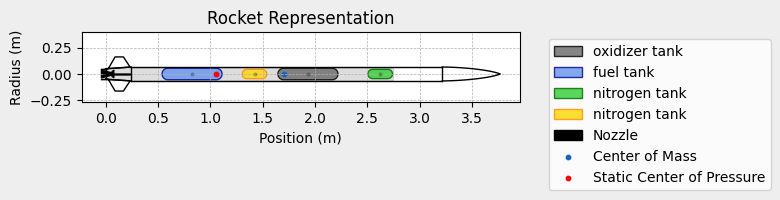

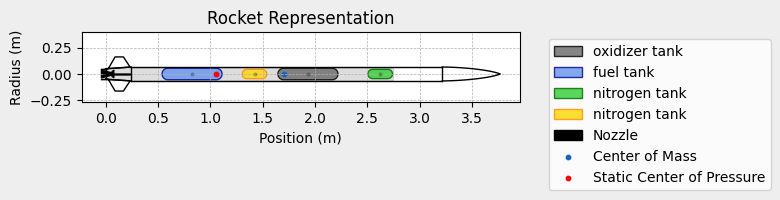

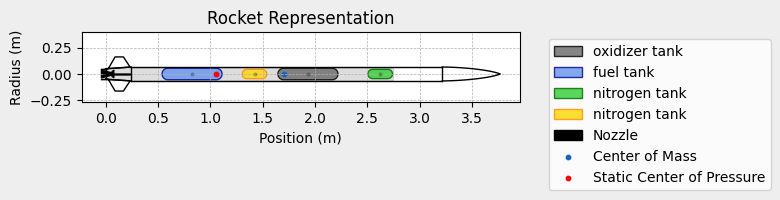

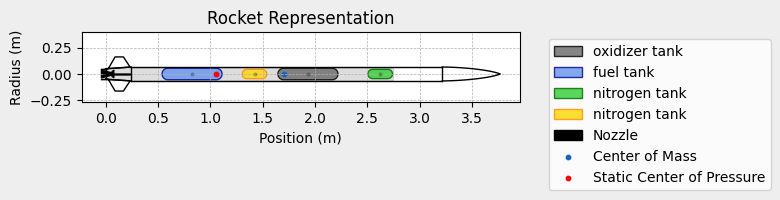

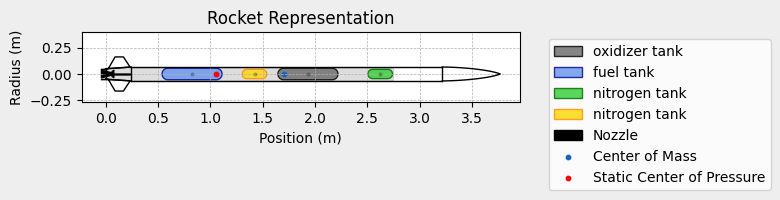

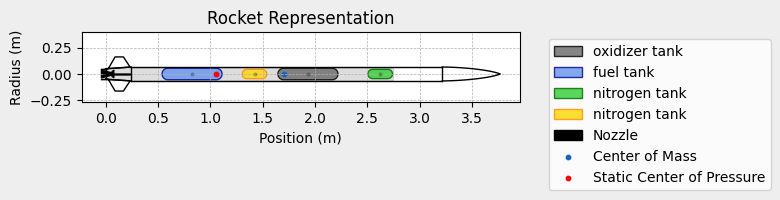

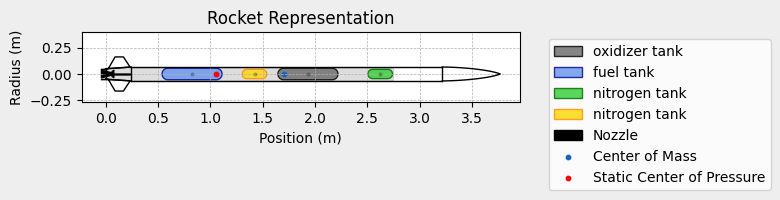

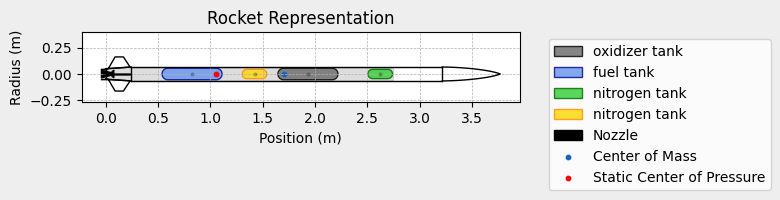

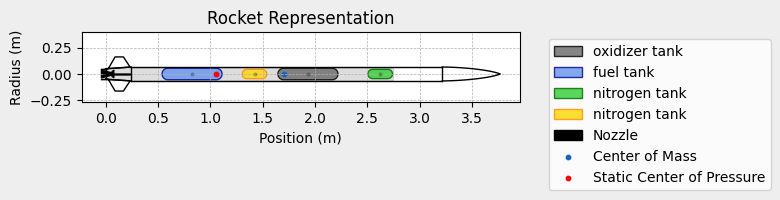


Inertia Details

Rocket Mass: 17.080 kg (without motor)
Rocket Dry Mass: 17.080 kg (with unloaded motor)
Rocket Loaded Mass: 26.805 kg
Rocket Structural Mass Ratio: 0.637
Rocket Inertia (with unloaded motor) 11: 16.800 kg*m2
Rocket Inertia (with unloaded motor) 22: 16.800 kg*m2
Rocket Inertia (with unloaded motor) 33: 0.025 kg*m2
Rocket Inertia (with unloaded motor) 12: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 13: 0.000 kg*m2
Rocket Inertia (with unloaded motor) 23: 0.000 kg*m2

Geometrical Parameters

Rocket Maximum Radius: 0.0664 m
Rocket Frontal Area: 0.013851 m2

Rocket Distances
Rocket Center of Dry Mass - Center of Mass without Motor: 0.000 m
Rocket Center of Dry Mass - Nozzle Exit: 1.853 m
Rocket Center of Dry Mass - Center of Propellant Mass: 0.298 m
Rocket Center of Mass - Rocket Loaded Center of Mass: 0.108 m


Aerodynamics Lift Coefficient Derivatives

Nose Cone Lift Coefficient Derivative: 2.000/rad
Tail Lift Coefficient Derivative: -0.915/rad
Freeform Lift Coeffic

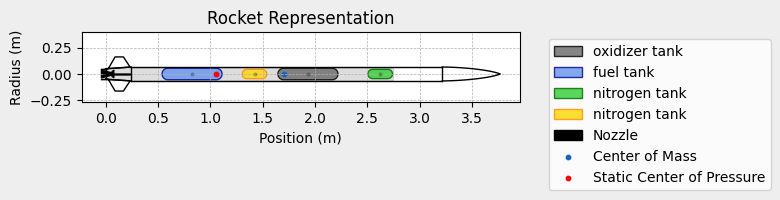


Mass Plots
----------------------------------------


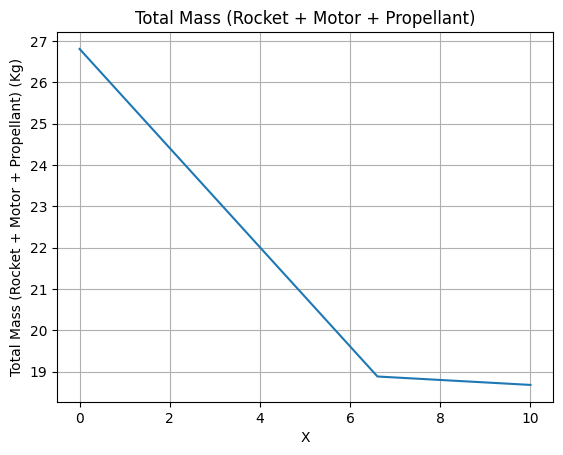

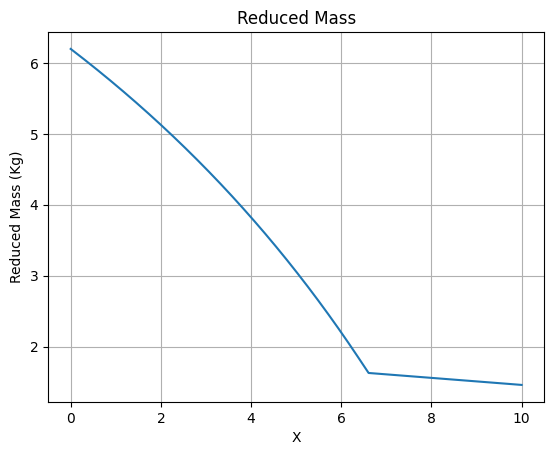


Aerodynamics Plots
----------------------------------------
Drag Plots
--------------------


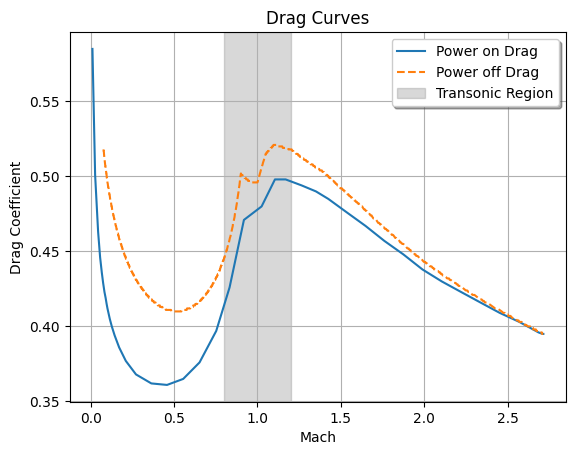


Stability Plots
--------------------


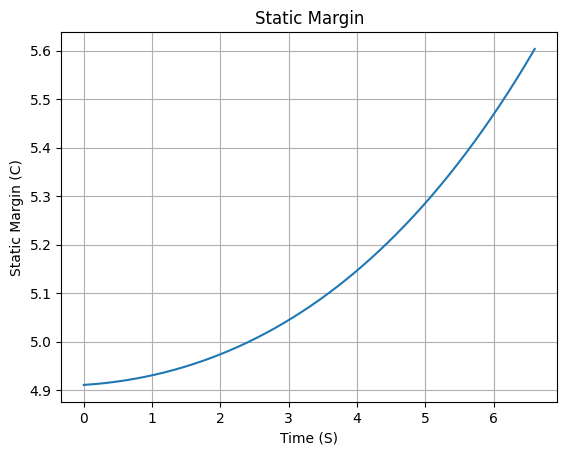

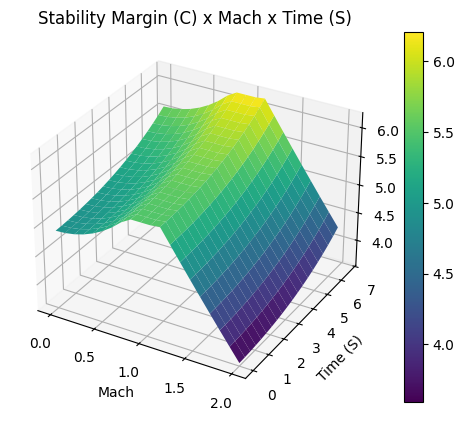


Thrust-to-Weight Plot
----------------------------------------


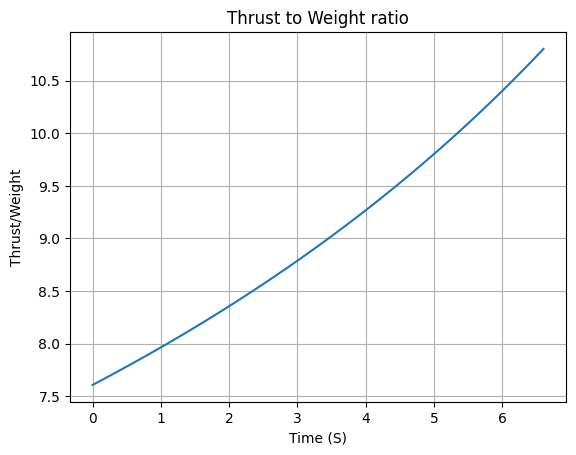

In [34]:
rockets = []
for i in range(len(data)):
  total_mass        = rocket_config["total_weight"]         / 1000  # kg

  if rocket_config["account_for_ice"]:
    total_mass += motor_config["mass"]["ice"]

  #inertia
  inertia_x_y   = rocket_config["moment_of_intertia_XY"]          # kg/m^2
  inertia_z     = rocket_config["moment_of_intertia_Z"]           # kg/m^2

  upper_railbutton_position = rocket_config["railbuttons"]["upper"]/1000
  lower_railbutton_position = rocket_config["railbuttons"]["lower"]/1000

  #CG
  CG                = rocket_config["total_CG"]             / 1000  # m


  hedy = Rocket(
      radius = rocket_diameter /2,                      # m
      mass = total_mass,                                # m
      inertia = (inertia_x_y, inertia_x_y, inertia_z),  # kg * m^2
      power_off_drag = "../power_off_drag.csv",
      power_on_drag = "../power_on_drag.csv",
      center_of_mass_without_motor = CG,                # m
      coordinate_system_orientation = "tail_to_nose"
  )
  hedy.add_motor(engines[i], position = 0)


  #hedy.set_rail_buttons(upper_button_position= upper_railbutton_position, lower_button_position=lower_railbutton_position)

  hedy.add_surfaces(surfaces=[nose_cone, fin_set, tail], positions=[rocket_length, 0, tailcone_length])

  hedy.parachutes = list(parachutes.values())

  #hedy.all_info()
  hedy.draw()

  rockets.append(hedy)
hedy.all_info()

### Flight

In [35]:
from os import name
from rocketpy.plots.compare import CompareFlights
from rocketpy import Environment, Flight, Rocket, SolidMotor
from datetime import datetime, timedelta

flights = []

for i in range(len(data)) :
  flight = Flight(
            environment = envNormal,
            rocket = rockets[i],
            rail_length =   flight_config["rail_length"], # m
            inclination =   flight_config["inclination"], # °
            heading =       flight_config["heading"],     # °
            terminate_on_apogee = True,
            name = str(data[i]/10) + "kg/s " + str(motor_config["thrust"]) +"N"
    )
  flights.append(flight)
  print(str((i+1)/len(data)*100)+ "% done")


11.11111111111111% done
22.22222222222222% done
33.33333333333333% done
44.44444444444444% done
55.55555555555556% done
66.66666666666666% done
77.77777777777779% done
88.88888888888889% done
100.0% done



Burn out State

Burn out time: 10.456 s
Altitude at burn out: 3350.497 m (ASL) | 3350.497 m (AGL)
Rocket speed at burn out: 597.384 m/s
Freestream velocity at burn out: 597.384 m/s
Mach Number at burn out: 1.829
Kinetic energy at burn out: 3.369e+06 J

Apogee State

Apogee Time: 44.173 s
Apogee Altitude: 10283.743 m (ASL) | 10283.743 m (AGL)
Apogee Freestream Speed: 28.795 m/s
Apogee X position: 1120.524 m
Apogee Y position: -1044.906 m
Apogee latitude: 39.1142927°
Apogee longitude: -8.0203567°
/////////////////////////////////////////////

Burn out State

Burn out time: 9.776 s
Altitude at burn out: 2980.505 m (ASL) | 2980.505 m (AGL)
Rocket speed at burn out: 572.765 m/s
Freestream velocity at burn out: 572.765 m/s
Mach Number at burn out: 1.746
Kinetic energy at burn out: 3.097e+06 J

Apogee State

Apogee Time: 42.300 s
Apogee Altitude: 9428.366 m (ASL) | 9428.366 m (AGL)
Apogee Freestream Speed: 27.328 m/s
Apogee X position: 1019.088 m
Apogee Y position: -950.315 m
Apogee latitude

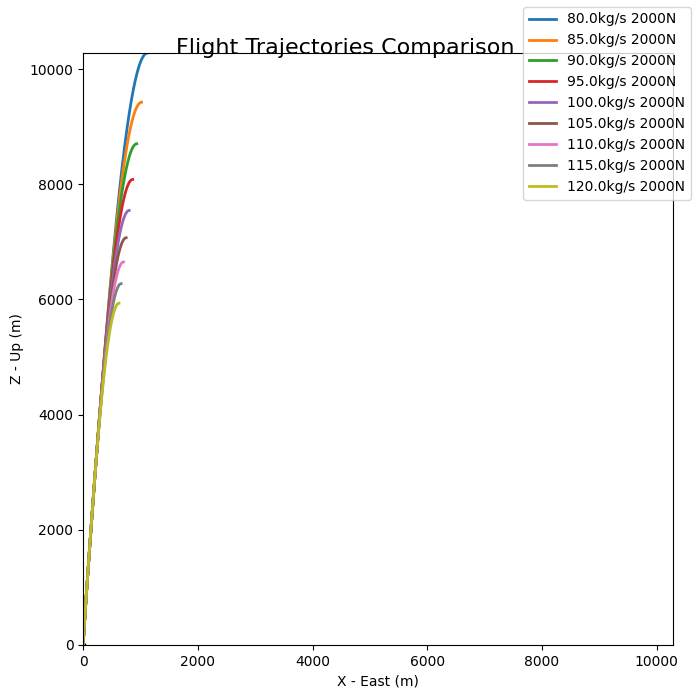

In [36]:
for i in range(len(data)) :
  flight = flights[i]
# flight.prints.out_of_rail_conditions()
  flight.prints.burn_out_conditions()
  flight.prints.apogee_conditions()
# flight.prints.impact_conditions()
# flight.prints.maximum_values()
# flight.plots.trajectory_3d()
# flight.plots.stability_and_control_data()
# flight.plots.all()
# flight.prints.all()
# flight.all_info()
  print("/////////////////////////////////////////////")

comparison = CompareFlights(flights)
comparison.trajectories_2d(plane = 'xz', legend = True)